In [ ]:
# команды 
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install sympy

In [1]:
import numpy as np
from scipy.spatial import ConvexHull,convex_hull_plot_2d
import matplotlib.pyplot as plt
import sympy as sym
from sympy import symbols, Function, Eq, solve, I, collect, expand, simplify,\
                  Derivative, init_printing, series, evaluate, Poly

init_printing() # Для красивой печати

x,y = symbols("x y",real=True) # переменные по умолчанию

In [2]:
def SCH(f,varlst=(x,y)):
    if not isinstance(f,Poly): fpoly = Poly(f,varlst)
    else: fpoly = f
    support=np.array([[x,y] for x,y in fpoly.monoms()],dtype=np.int32)
    CH=ConvexHull(support)
    #print(support[CH.vertices])
    return support,CH

def Normlst(CH,S):
    eps = 10**(-7)
    edgelst = CH.simplices
    eqnlst = CH.equations
    #midpntlst = np.array([(S[edge[0]]+S[edge[1]])/2 for edge in edgelst],dtype=np.float64)
    normlst = []
    for eq in eqnlst:
        if np.abs(eq[0]*eq[1])>eps:
            coordmin = np.min(np.abs(eq[:-1]))
            normlst.append(eq/coordmin)
        else:
            normlst.append(eq)
    normlst = np.array(normlst,dtype=np.int32)
    return normlst #list(zip(normlst,midpntlst))

def GetTrunc(f,edgenum,varlst=(x,y)):
    eps = 10**(-7)
    if not isinstance(f,Poly): fpoly = Poly(f,varlst)
    else: fpoly = f
    support,CH = SCH(fpoly,varlst)
    if edgenum >= len(CH.equations): return Null
    else: eqcoeffs = CH.equations[edgenum]
    eq = lambda p,q: eqcoeffs[0]*p+eqcoeffs[1]*q+eqcoeffs[2]
    monomlst = [fpoly.coeff_monomial((p,q))*varlst[0]**p*varlst[1]**q for (p,q) in\
               fpoly.monoms() if np.abs(eq(p,q))<eps]
    return sum(monomlst)

   
def NPimage(CH,S,ecol="k",vcol="b"):
    def getlimits(S):
        npS = np.array(S,dtype=np.int32)
        return np.array([np.min(npS[:,0]),np.max(npS[:,0]),np.min(npS[:,1]),\
                         np.max(npS[:,1])],dtype=np.int32)
    delta = 0.4
    polylimits = getlimits(S)
    enlarge = np.array([-delta,delta,-delta,delta],dtype=np.float64)
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)
    ax.axis('square')
    ax.axis(polylimits+enlarge)
    majorx_ticks = np.arange(polylimits[0],polylimits[1]+1,1)
    majory_ticks = np.arange(polylimits[2],polylimits[3]+1,1)
    ax.set_xticks(majorx_ticks)
    ax.set_yticks(majory_ticks)
    ax.grid(which='major',color="grey",linestyle='-',lw=1,alpha=0.5)
    ax.set_xlabel("$q_1$",fontsize=16)
    ax.set_ylabel("$q_2$",fontsize=16,rotation=0)
    for i,edge in enumerate(CH.simplices):
        ax.plot(S[edge,0], S[edge,1],ecol+'-', lw=2)
    ax.plot(S[:,0], S[:,1], vcol+'o')
    return ax

def AddEdgeLabel(ax,support,CH,normlst,edgenum,text,shift=0.25):
    midpnt = (support[CH.simplices[edgenum][0]]+support[CH.simplices[edgenum][1]])/2
    lblpos = midpnt+shift*normlst[edgenum][:-1]
    ax.text(*lblpos,text,fontsize=16)#,position=lblpos)

Задание: найдите начальные члены разложения всех ветвей алгебраической кривой вблизи нуля. Графически сравните полученные решения с точными значениями.

2. $(x^2+y^2)^2+3yx^2-y^3$ 

In [3]:
f = (x**2 + y**2)**2 + 3 * y * x**2 - y**3
f = f.expand()
f

In [4]:
# Вычисляем его носитель, многоугольник Ньютона и список нормалей
S,C = SCH(f,[x,y])
normlst = Normlst(C,S)
[(i,normal) for i,normal in enumerate(normlst)]

[(0, array([ 1,  1, -4])),
 (1, array([-1, -2,  4])),
 (2, array([-1,  0,  0])),
 (3, array([-1, -1,  3]))]

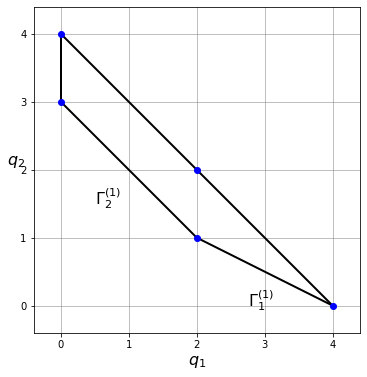

In [5]:
# Изобразим многоугольник и отметим ребро с отрицательной нормалью
ax1 = NPimage(C,S)
AddEdgeLabel(ax1,S,C,normlst,1,r'$\Gamma_1^{(1)}$', 0.25)
AddEdgeLabel(ax1,S,C,normlst,3,r'$\Gamma_2^{(1)}$', 0.5)
plt.show()

In [6]:
# Находим укороченный многочлен, соответствующий ребру с номером 1
# Раскладываем его на множители
f1 = GetTrunc(f,1).factor()
f1

In [7]:
# Находим укороченный многочлен, соответствующий ребру с номером 1
f2 = GetTrunc(f,3).factor()
f2

In [8]:
sol1 = solve(f1,y) 
sol1

In [9]:
sol2 = solve(f2,y) 
sol2

In [10]:
# Изобразим решения уравнения f(x,y)=0 численно
# Определим функции для эффективного вычисления многочлена и вычисленных корней
vf = sym.lambdify([x,y],f,"numpy")
roots = [sym.lambdify(x,root,"numpy") for root in sol2]
roots.append(sym.lambdify(x,sol1[0],"numpy"))

In [11]:
# Зададим сетку 
xmin,xmax = -0.5, 1.5
ymin,ymax = -0.5, 1.5
N = 1500
xdiap = np.linspace(xmin,xmax,N)
xrdiap = np.linspace(0,1,N)
ydiap = np.linspace(ymin,ymax,N)
X,Y = np.meshgrid(xdiap,ydiap)
Z = vf(X,Y)
roots_vals = [v(xrdiap) for v in roots]

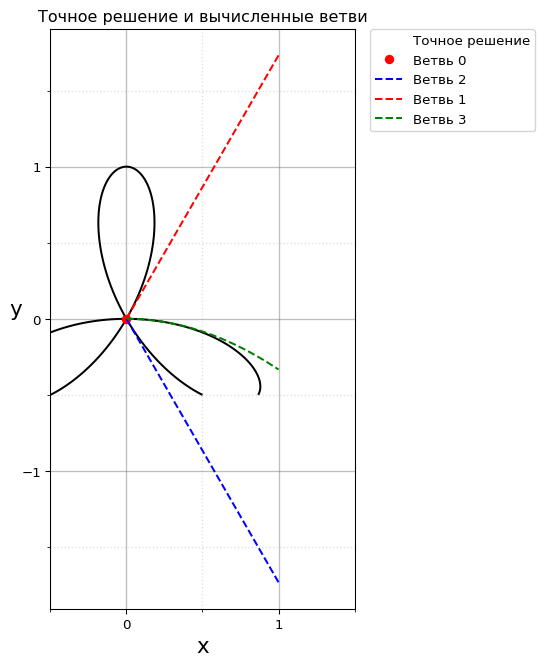

In [12]:
fig=plt.figure(figsize=(8,8),dpi=96)
cplt1=fig.add_subplot(111, aspect='equal',autoscale_on=True)
cplt1.set_xlabel('x', fontsize=16)
cplt1.set_ylabel('y', fontsize=16, rotation=0)
major_ticks = np.arange(-2, 3, 1)
minor_ticks = np.arange(-1.5, 3, 1)
#cplt1.set_ylim([ymin,ymax])
cplt1.set_title("Точное решение и вычисленные ветви")
cplt1.set_xticks(major_ticks)
cplt1.set_xticks(minor_ticks, minor=True)
cplt1.set_yticks(major_ticks)
cplt1.set_yticks(minor_ticks, minor=True)
cplt1.grid(which='major',color="grey",linestyle='-',lw=1,alpha=0.5)
cplt1.grid(which='minor',color="grey",linestyle=':',lw=1,alpha=0.25)
cplt1.set_aspect('equal')

cntr = cplt1.contour(X,Y,Z,[0],linewidths=1.5,linestyles='-',colors='k')
cntr.collections[0].set_label("Точное решение")
cplt1.plot(0,roots_vals[0],'ro',label="Ветвь 0")
cplt1.plot(xrdiap,roots_vals[1],'b--',label="Ветвь 2")
cplt1.plot(xrdiap,roots_vals[2],'r--',label="Ветвь 1")
cplt1.plot(xrdiap,roots_vals[3],'g--',label="Ветвь 3")
cplt1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()